In [26]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## 1. Ensamblados para regresión
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.


>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.

In [2]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

In [3]:
df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure,y_value
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000


> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.

In [4]:
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
#df.drop(["date"], axis=1, inplace=True) #delete date
params = ['meantemp','humidity','wind_speed','meanpressure','y_value']
cols = ['meantemp','humidity','wind_speed','meanpressure','y_value','cday','year','month','season_fall','season_rainy','season_summer','season_winter']
df[cols].head(5)

,meantemp,humidity,wind_speed,meanpressure,y_value,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,7.400000,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,7.166667,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,8.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,6.000000,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,7.000000,5,2013,1,0,0,0,1


> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.

In [5]:
y = df[cols].pop("y_value").values
X = df[cols].values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

In [6]:
df[params].describe()

,meantemp,humidity,wind_speed,meanpressure,y_value
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.506127,60.744851,6.806865,1011.101197,25.506127
std,7.339416,16.743928,4.559688,180.293335,7.339416
min,6.000000,13.428571,0.000000,-3.041667,6.000000
25%,18.857143,50.375000,3.475000,1001.571429,18.857143
50%,27.714286,62.625000,6.250000,1008.555556,27.714286
75%,31.312500,72.125000,9.250000,1014.937500,31.312500
max,38.714286,98.000000,42.220000,7679.333333,38.714286


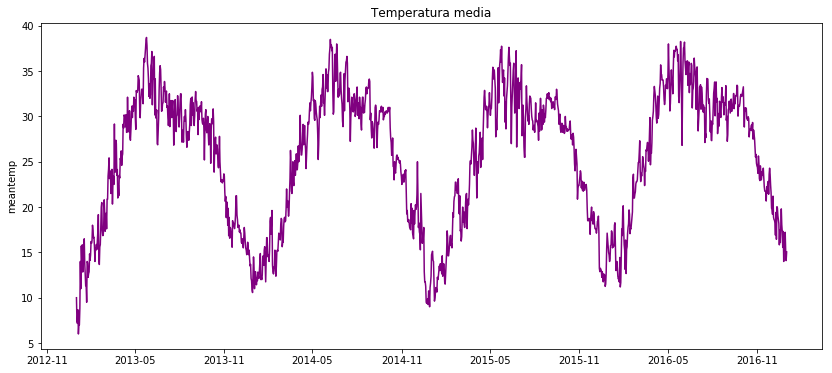

In [7]:
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['meantemp'],c='purple')
plt.ylabel("meantemp")
plt.title('Temperatura media')
plt.show()

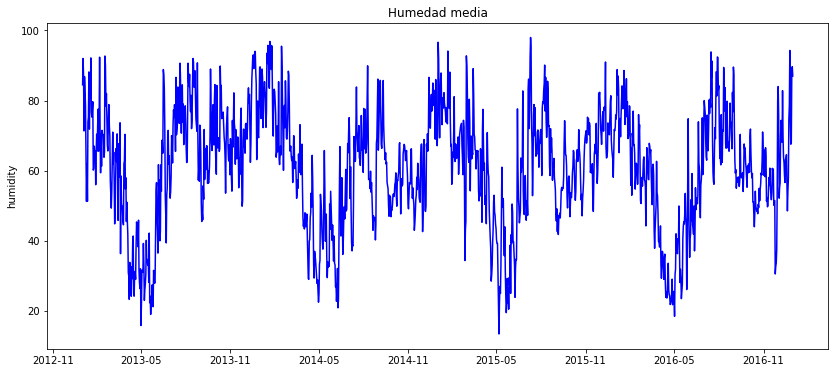

In [24]:
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['humidity'],c='blue')
plt.ylabel("humidity")
plt.title('Humedad media')
plt.show()

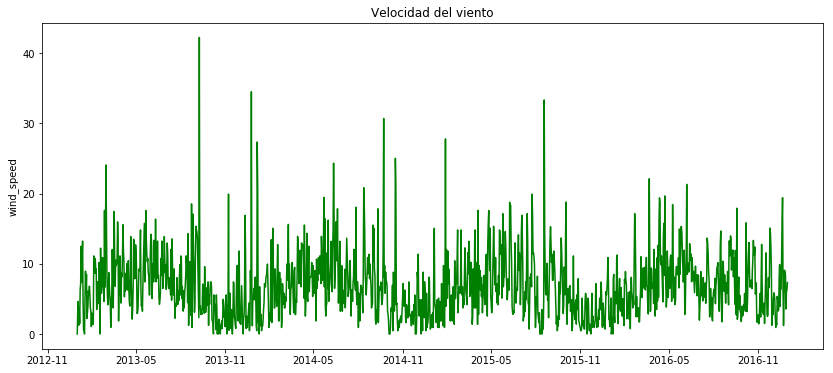

In [9]:
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['wind_speed'],c='green')
plt.ylabel("wind_speed")
plt.title('Velocidad del viento')
plt.show()

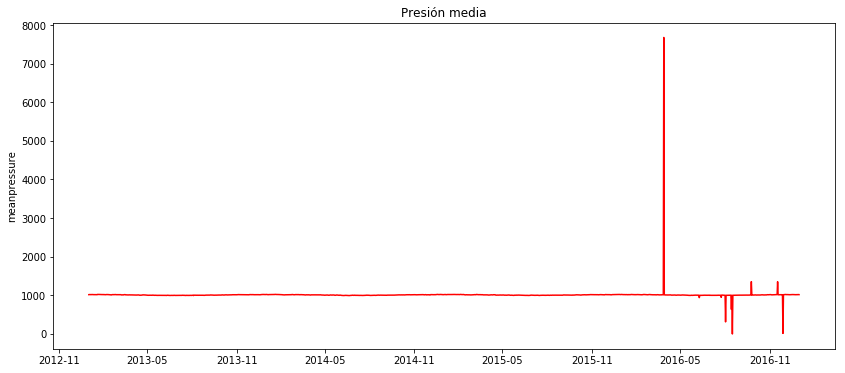

In [10]:
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['meanpressure'],c='red')
plt.ylabel("meanpressure")
plt.title('Presión media')
plt.show()

Existen outliers muy conotados en la presión que no pereciesen estar relacionados con la temporalidad de data, por lo que se removeran del dataframe.

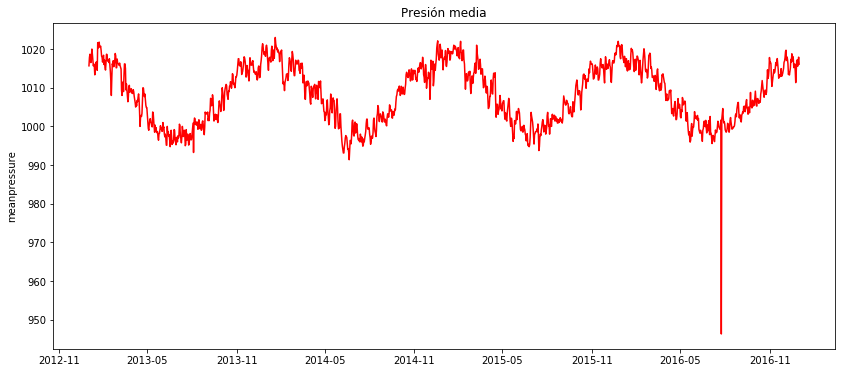

In [40]:
plt.figure(figsize=(14,6))
plt.plot(df[(np.abs(stats.zscore(df['meanpressure'])) < 0.4)]['date'], df[(np.abs(stats.zscore(df['meanpressure'])) < 0.4)]['meanpressure'],c='red')
plt.ylabel("meanpressure")
plt.title('Presión media')
plt.show()


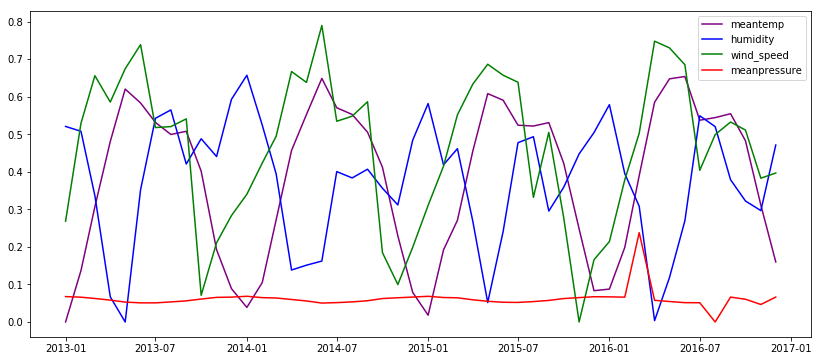

In [22]:
#dummy df para rescalar datos y comparar las distintas escalas
dummy = df[params+['month','year']].copy()
#agrupar por mes y año
dummy = dummy.groupby(['year','month']).mean().reset_index()
for para in params:
    dummy[para] = (dummy[para]-dummy[para].min())/dummy[para].max()
dummy['date'] = dummy['year'].astype(str) +'-'+dummy['month'].astype(str)
dummy["date"] = pd.to_datetime(dummy["date"])
#plot by month,year
plt.figure(figsize=(14,6))
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(dummy['date'], dummy['humidity'],c='blue')
plt.plot(dummy['date'], dummy['wind_speed'],c='green')
plt.plot(dummy['date'], dummy['meanpressure'],c='red')
plt.legend()
plt.show()
